## Seguimiento de la practica 1

En este juypyter se explican dudas que han sido frecuentes en varios grupos asi como ejemplos de pruebas y/o visualizaciones que podeis hacer.
Como se ha mencionado en clase, usad lo que os haga falta acorde a vuestros datos y ampliad el contenido mas allá de lo que se explica en el guión y en este notebook

La base de datos que se usa en estos ejemplos trata los datos de una aseguradora sobre sus asegurados y el objetivo es predecir el coste que le supone a la empresa tener asegurado a cada persona

### Importante!
### El material del jupyter anterior es un "Guión de practicas". A partir de los ejemplos que se os facilitan, teneis que seguir desarrollando la practica de forma autonoma

#### Ejemplos que os pueden ser de ayuda para empezar a ampliar la practica

 - Apartado C: Atributos derivados que os aporten mas información (at1 * at2 =at3); tratamiento de datos categoricos; gestion de nans; gestion de desbalanceo de datos (oversampling y undersampling); ...
 - Apartado B: Regresiones multivariadas, polinomiales, PCA, algoritmos de robustez contra outliers (RANSAC); ...
 - Apartado A: Regularizadores; momentum; ...


In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import normaltest

%matplotlib inline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [168]:
df = pd.read_csv('follow_insurance.csv')
idx = df.sample(frac=0.7).index

train_df = df[df.index.isin(idx)]
test_df = df[~df.index.isin(idx)]


train_df_x = train_df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
train_df_y = train_df['expenses']

test_df_x = test_df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
test_df_y = test_df['expenses']

print(df.columns)
print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses'], dtype='object')
Train: (937, 7)
Test: (401, 7)


In [169]:
train_df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
6,46,female,33.4,1,no,southeast,8240.59
...,...,...,...,...,...,...,...
1330,57,female,25.7,2,no,southeast,12629.17
1331,23,female,33.4,0,no,southwest,10795.94
1332,52,female,44.7,3,no,southwest,11411.69
1333,50,male,31.0,3,no,northwest,10600.55


In [170]:
# Mirar por encima los datos (tipos, valores, ....)
for i in train_df.columns:
    if train_df[i].dtype == 'object':
        print(f"{i} \nNaNs: {train_df[i].isna().sum()}\nValues: {train_df[i].unique()}", )
    else:
        print(f"{i} \nNaNs: {train_df[i].isna().sum()}\nMean_std: {train_df[i].mean():.3f} {train_df[i].std():.3f}", )

age 
NaNs: 0
Mean_std: 38.834 13.947
sex 
NaNs: 0
Values: ['female' 'male']
bmi 
NaNs: 0
Mean_std: 30.432 6.106
children 
NaNs: 0
Mean_std: 1.086 1.187
smoker 
NaNs: 0
Values: ['yes' 'no']
region 
NaNs: 0
Values: ['southwest' 'southeast' 'northwest' 'northeast']
expenses 
NaNs: 0
Mean_std: 12823.671 11712.530


Las variables categoricas no las podeis usar tal cual estan en la base de datos y para poder trabajar con ellas las teneis que convertir a numericas:
 - Nominales: No hay ninguna relacion aparente entre los diferentes valores que puede tener la variable (Lista de accesorios disponibles en un coche)
     - One-hot encoding para las categoricas nominales (p.e. Norte, sur, este, oeste,.... )
 - Ordinales: Si que existe una relación de orden entre los valores (Niveles de educación)
     - Conservar el labeling numerico para las categoricas ordinales (p.e. A1, A2, B1, B2, C1, .... )

A la hora de tratar las nominales, podeis tratarlas como multiples variables binarias donde cada nuevo atributo se corresponde a uno de los valores que existian

In [171]:
# 1-hot encode all string attributes. This assumes each sample contains only one posible value 

def replace_categorical(df):  
    columns = df.columns
    for col in columns:
        if df[col].dtype == 'object':
            print(f"{col} is categorical")
            df = pd.concat([df, pd.get_dummies(df[col],prefix=col)], axis=1)
            df = df.drop(columns=col)
    
    return df

train_df_x = replace_categorical(train_df_x)
test_df_x = replace_categorical(test_df_x)

train_df_x = train_df_x.drop(columns=['sex_female', 'smoker_no'])
test_df_x = test_df_x.drop(columns=['sex_female', 'smoker_no'])
pd.get_dummies(pd.Series(list('acba')))

sex is categorical
smoker is categorical
region is categorical
sex is categorical
smoker is categorical
region is categorical


,a,b,c
0,1,0,0
1,0,0,1
2,0,1,0
3,1,0,0


### Gestionar nans
La idea tras esto es que minimiceis los datos que vais a perder cuanto teneis muestras incompletas o con errores.
Dependiendo de la situación en la que esteis y vuestros datos debereis decantaros por una opcion o por otra.

- Si los nans estan concetrados en unas pocas muestras (-5%), podeis simplemente eliminar las muestras.
- Si os faltan muchos datos de un mismo atributo (+40%), podeis eliminar el atributo ya que os implica eliminar muchas muestras.    
- Podeis rellenar los nans con valores generados a partir de la distribucion de datos que teneis. Ya sea directamente mirando los valores cercanos (media, moda, mediana), o con algormitmos que tengan en cuenta mas de un atributo (usar KNN para asignar la media de k-valores mas cercanos a los datos faltantes) 

In [172]:
def handle_nans(df, strategy='zeros'):
    columns = df.columns
    for col in columns:    
        nans = df[col].isnull().sum()
        if nans > 0:
            if strategy == 'drop':
                df.drop(columns=col, inplace=True)
            elif strategy == 'zeros':
                df.loc[df[col].isnull(), col] = 0
            elif strategy == 'mean':
                df.loc[df[col].isnull(), col] = df.loc[~df[col].isnull(). col].mean()
            elif strategy == 'mean_noise':
                pass

    return df

train_df_x = handle_nans(train_df_x)
test_df_x = handle_nans(test_df_x)

### Identificar el tipo de distribución

Podeis hacerlo graficamente mediante histogramas, boxplots, QQPlots, ...

O podeis usar distintos test estadisticos para confirmar el tipo de distribucion de cada atributo

Desde numpy podeis generar arrays de N elementos que sigan una distribucion especifica para facilitar la comparación con vuestros datos 

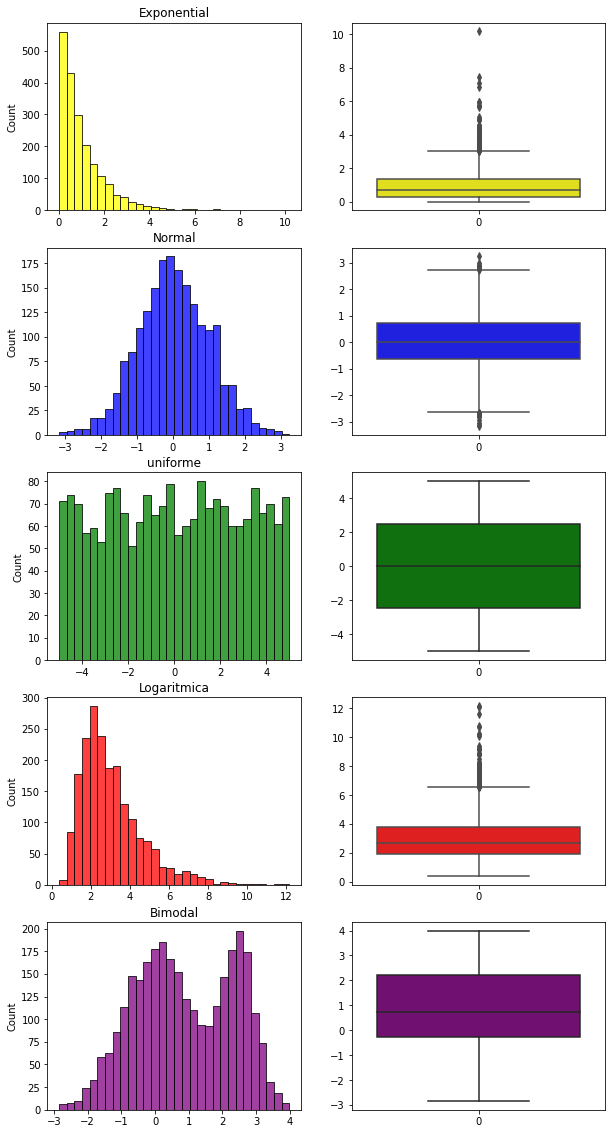

In [173]:
# 
samples = 2000

fig, axes = plt.subplots(5,2, figsize=(10, 20))
exp = np.random.exponential(1, samples)
norm = np.random.randn(samples,)
uni = np.random.uniform(-5, 5, samples)
logn = np.random.lognormal(1, .5, samples)
bim = np.concatenate([np.random.normal(0, 1, size=samples),np.random.normal(2.5, .5, size=samples // 2)])

sns.histplot(x=exp, color='yellow', ax=axes[0,0], bins=30)
sns.histplot(x=norm, color='blue', ax=axes[1, 0], bins=30)
sns.histplot(x=uni, color='green', ax=axes[2, 0], bins=30)
sns.histplot(x=logn, color='red', ax=axes[3, 0], bins=30)
sns.histplot(x=bim, color='purple', ax=axes[4, 0], bins=30)

sns.boxplot(data=exp, color='yellow', ax=axes[0,1])
sns.boxplot(data=norm, color='blue', ax=axes[1, 1])
sns.boxplot(data=uni, color='green', ax=axes[2, 1])
sns.boxplot(data=logn, color='red', ax=axes[3, 1])
sns.boxplot(data=bim, color='purple', ax=axes[4, 1])


axes[0,0].set_title('Exponential')
axes[1,0].set_title('Normal')
axes[2,0].set_title('uniforme')
axes[3,0].set_title('Logaritmica')
axes[4,0].set_title('Bimodal')

plt.show()

In [174]:
for idx, dist in enumerate([norm, exp, uni, logn, bim]):

    stat, p = normaltest(dist)
    alpha = .05

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print(f"The null hypothesis can be rejected")
    else:
        print(f"The null hypothesis cannot be rejected (comes from a normal dist)")


The null hypothesis cannot be rejected (comes from a normal dist)
The null hypothesis can be rejected
The null hypothesis can be rejected
The null hypothesis can be rejected
The null hypothesis can be rejected


### Normalizacion y Desnormalizacion

Cuando trabajeis con datos normalizados, acordaos de desnormalizarlos antes de contextualizar los resultados en vuestro dataset.

Tambien teneis que tener en cuenta que la media y la std se han de calcular solo sobre el conjunto de training, ya que si lo hacemos sobre todos la base de datos, estariamos filtrando informacion del conjunto de validacion a nuestor modelo


In [175]:
# normalizar

def standarize(x, mean=None, std=None):
    if mean is None:
        mean = x.mean(0)
    if std is None:
        std = x.std(0)
    
    return (x - mean[None, :]) / std[None, :], mean, std

train_df_x_norm, mean, std = standarize(train_df_x.values)
test_df_x_norm, _, _ = standarize(test_df_x.values, mean, std)

train_df_y_norm, mean, std = standarize(train_df_y.values[:, None])
test_df_y_norm, _, _ = standarize(test_df_y.values[:, None], mean, std)

2. Amb quin atribut s'assoleix un MSE menor?

4. Com influeix la normalització en la regressió?

<AxesSubplot:>

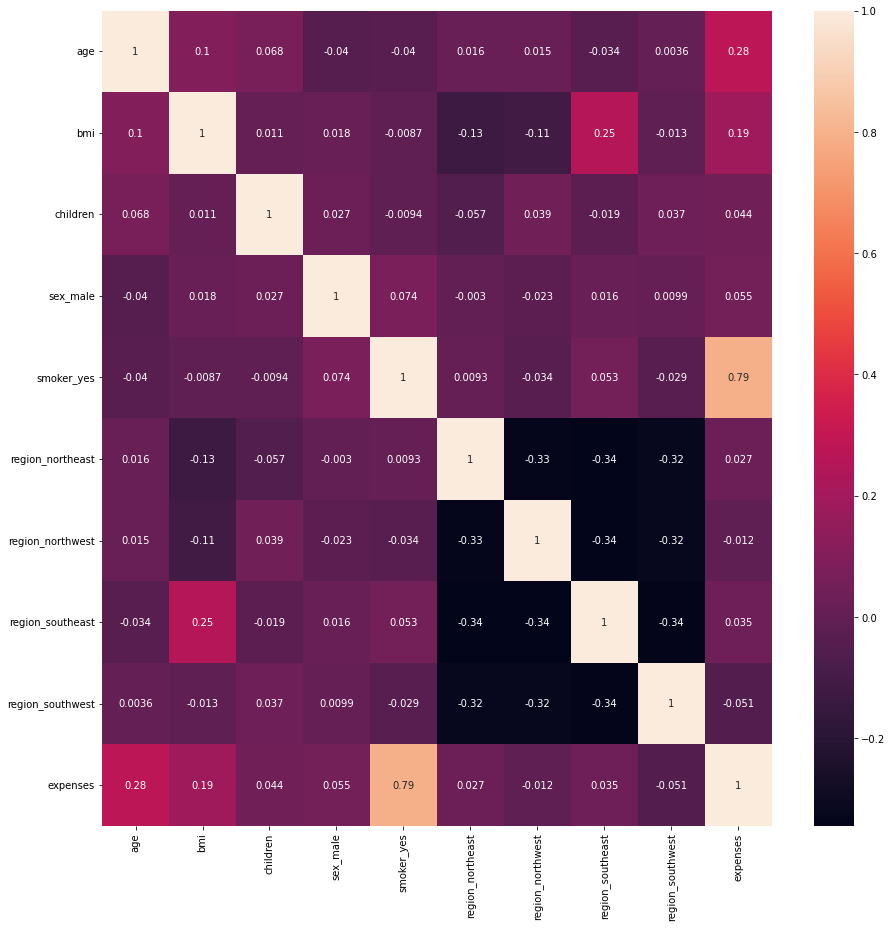

In [176]:
correlation_df = pd.concat([train_df_x, train_df_y], axis=1)
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlation_df.corr(), annot=True)


age - MSE: 1.101; R2: 0.098; MAE: 0.799
bmi - MSE: 1.176; R2: 0.036; MAE: 0.818
children - MSE: 1.226; R2: -0.005; MAE: 0.813
sex_male - MSE: 1.232; R2: -0.010; MAE: 0.812
smoker_yes - MSE: 0.490; R2: 0.599; MAE: 0.523
region_northeast - MSE: 1.239; R2: -0.016; MAE: 0.812
region_northwest - MSE: 1.234; R2: -0.011; MAE: 0.811
region_southeast - MSE: 1.225; R2: -0.004; MAE: 0.809
region_southwest - MSE: 1.236; R2: -0.013; MAE: 0.812


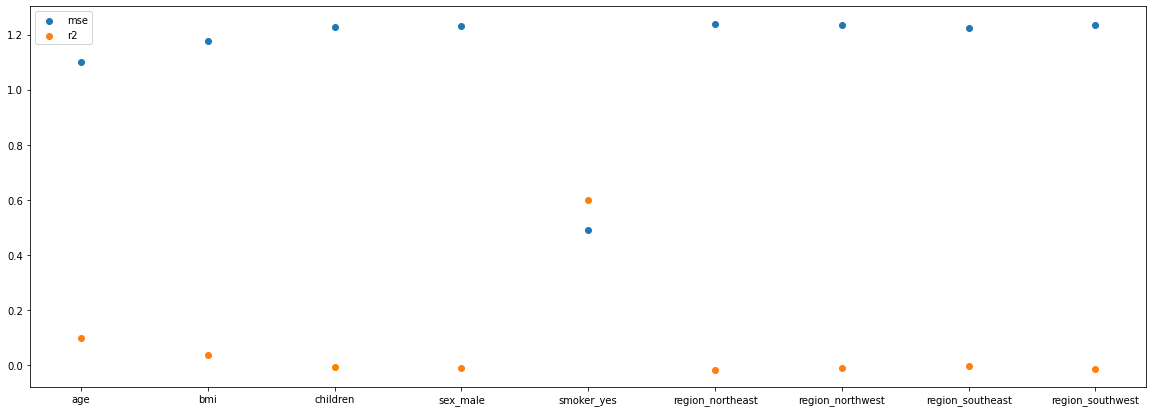

In [177]:
linear_model = LinearRegression()    

features = train_df_x.columns
train_y = train_df_y_norm
test_y = test_df_y_norm

mses, r2s = [], []
features = features.tolist()

mses, r2s = [], []
for idx, feature in enumerate(features):
    linear_model.fit(train_df_x_norm[:, idx, None], train_df_y_norm)
    preds = linear_model.predict(test_df_x_norm[:, idx, None])
       
    mse = mean_squared_error(test_df_y_norm, preds)
    mae = mean_absolute_error(test_df_y_norm, preds)
    mses.append(mse)
    
    r2 = r2_score(test_y, preds)
    r2s.append(r2)

    print(f"{feature} - MSE: {mse:.3f}; R2: {r2:.3f}; MAE: {mae:.3f}")

mses = np.array(mses)
r2s = np.array(r2s)
plt.figure(figsize=(20,7)) 
plt.scatter(features, mses, label='mse')
plt.scatter(features, r2s, label='r2')
plt.legend()
plt.show()

<AxesSubplot:>

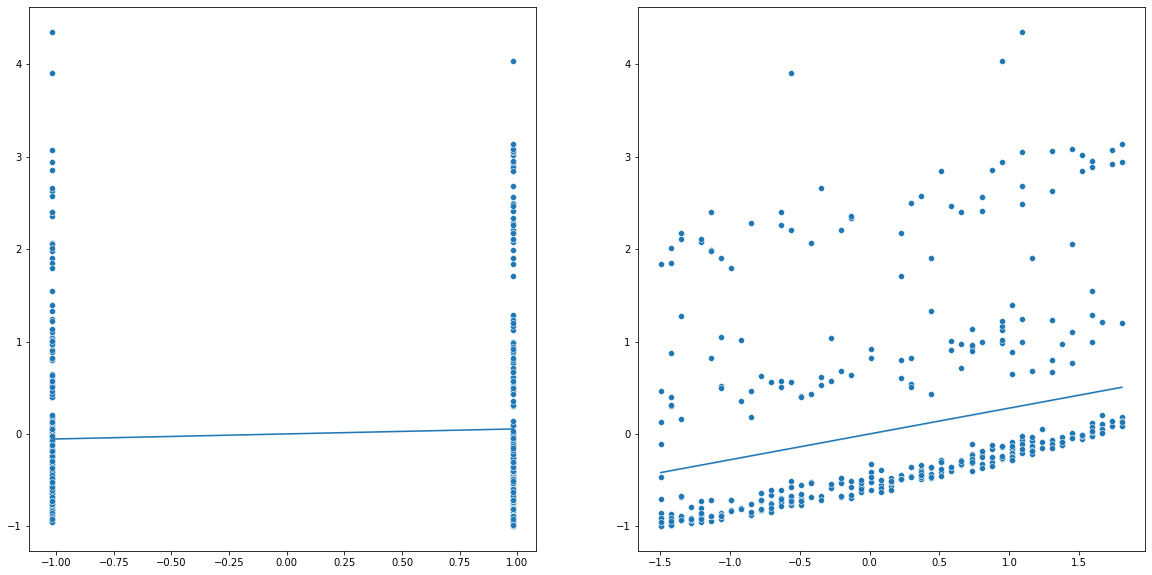

In [178]:
f, ax = plt.subplots(1, 2, figsize=(20,10))
smoke = linear_model.fit(train_df_x_norm[:, 3, None], train_df_y_norm)
preds_smoke = smoke.predict(test_df_x_norm[:, 3, None])
age = linear_model.fit(train_df_x_norm[:, 0, None], train_df_y_norm)
preds_age = smoke.predict(test_df_x_norm[:, 0, None])


sns.lineplot(y=preds_smoke[:,0], x=test_df_x_norm[:, 3], ax=ax[0])
sns.scatterplot(y=test_df_y_norm[:,0], x=test_df_x_norm[:, 3], ax=ax[0])


sns.lineplot(y=preds_age[:,0], x=test_df_x_norm[:, 0], ax=ax[1])
sns.scatterplot(y=test_df_y_norm[:,0], x=test_df_x_norm[:, 0], ax=ax[1])


0.7109506154045473 by taking into account smoking and age


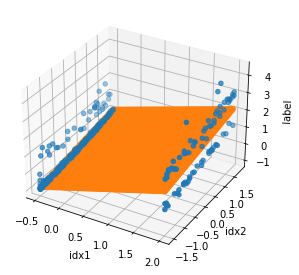

In [179]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(1, 2, 1, projection='3d')

linear_model = LinearRegression()    

idxs = [4,0]
model = linear_model.fit(train_df_x_norm[:, idxs], train_df_y_norm)
score = model.score(test_df_x_norm[:, idxs], test_df_y_norm)

# plot de los puntos en los 3 ejes: los 2 atributos y el valor real a predecir (y)
ax.scatter(test_df_x_norm[:, idxs[0]], test_df_x_norm[:, idxs[1]], test_df_y_norm[:,0])

# creamos una malla de samples sobre las que queremos predecir el valor
x_pred, y_pred = np.meshgrid(
    np.linspace(test_df_x_norm[:, idxs[0]].min(), test_df_x_norm[:, idxs[0]].max(), 100),
    np.linspace(test_df_x_norm[:, idxs[1]].min(), test_df_x_norm[:, idxs[1]].max(), 100),
)
to_pred = np.array([x_pred.flatten(), y_pred.flatten()]).T

preds_smoke_age = model.predict(to_pred)

# ploteamos todos los puntos que conforman la malla para generar el plano de puntos
ax.scatter(x_pred.flatten(), y_pred.flatten(), preds_smoke_age)

ax.set_xlabel('idx1')
ax.set_ylabel('idx2')
ax.set_zlabel('label')

print(score, "by taking into account smoking and age")

PCA_1 - MSE: 1.163; R2: 0.047
PCA_2 - MSE: 1.155; R2: 0.053
PCA_3 - MSE: 1.158; R2: 0.051
PCA_4 - MSE: 1.148; R2: 0.059
PCA_5 - MSE: 0.852; R2: 0.302
PCA_6 - MSE: 0.407; R2: 0.667
PCA_7 - MSE: 0.325; R2: 0.734
PCA_8 - MSE: 0.322; R2: 0.736


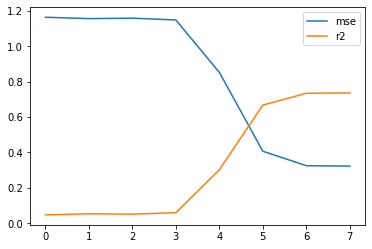

In [181]:
mses, r2s = [], []
for i in range(1, 9):
    pca = PCA(n_components=i)
    x_train = pca.fit_transform(train_df_x_norm)
    x_test = pca.transform(test_df_x_norm)

    linear_model = LinearRegression()
    linear_model.fit(x_train, train_df_y_norm)
    preds = linear_model.predict(x_test)

    mse = mean_squared_error(test_df_y_norm, preds)
    r2 = r2_score(test_df_y_norm, preds)
    print(f"PCA_{i} - MSE: {mse:.3f}; R2: {r2:.3f}")
    
    mses.append(mse)
    r2s.append(r2)
    
plt.plot(mses, label='mse')
plt.plot(r2s, label='r2')
plt.legend()
plt.show()
